In [1]:
import pandas as pd
import numpy as np
from typing import Sequence
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('data/processed/cases_train.csv', parse_dates=['date_confirmation'])
train['date_confirmation'] = train['date_confirmation'].apply(lambda r: r.value)
# 0 hospitalized
# 1 nonhospitalized
# 6 deceased

# Label Encoding

In [3]:
le = LabelEncoder()
for col in train.columns:
    if train[col].dtype == 'object' and col != 'outcome_group':
        train[col] = le.fit_transform(train[col])

train['outcome_group'] = pd.Categorical(train['outcome_group']).codes
X = train.iloc[:, 0:-1]
y = train.iloc[:, -1]

In [4]:
print(train['outcome_group'].loc[6],train['outcome_group'].loc[0],train['outcome_group'].loc[1])

0 1 2


# Feature Selection

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8)

In [7]:
classifiers = [(LogisticRegression(),'Logistic Regression'),
                   (GaussianNB(),'GaussianNB'),
                   (KNeighborsClassifier(),'KNN'),
                   (DecisionTreeClassifier(),'Decision Tree'),
                   (SVC(),'Support Vector')]
    
best_score = 0
best_classifier = None
best_m:str = None
for (c,m) in classifiers:
    c.fit(X_train,y_train)
    valid_score = c.score(X_valid,y_valid)
    if valid_score > best_score:
        best_score = valid_score
        best_classifier = c
        best_m = m

print('proceeding with classifier {0} with valid score {1}'.format(best_m,round(best_score,6)))

cols: Sequence[str] = X_train.columns.to_list()
desired_n_features = round(len(cols)*0.75)

while (len(cols) != desired_n_features):
    print('working with {0}/{1} features'.format(len(cols),X_train.shape[1]))
    least_reduction = 1
    for f in cols:
        X_train_fs_no_f = X_train[cols]
        X_valid_fs_no_f = X_valid[cols]
        best_classifier.fit(X_train_fs_no_f,y_train)
        valid_score_no_f = best_classifier.score(X_valid_fs_no_f, y_valid)
        reduction = best_score-valid_score_no_f
        if reduction < least_reduction:
            print('reduction \\f {0}: {1}'.format(f,round(reduction,6)))
            least_reduction = reduction
            least_reduction_feature = f
    print('removing feature', least_reduction_feature)
    cols.pop(cols.index(least_reduction_feature))
print('done!')

proceeding with classifier KNN with valid score 0.93436
working with 14/14 features
reduction \f age: 0.0
removing feature age
working with 13/14 features
reduction \f sex: 0.0
removing feature sex
working with 12/14 features
reduction \f province: 0.003776
removing feature province
working with 11/14 features
reduction \f country: 0.003776
removing feature country
done!


# Balancing Dataset
#### Initialize KFold, 80:20 split, class weights, scoring criteria, use selected features

In [73]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore') 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score

X_train = X_train[cols]
X_valid = X_valid[cols]
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_valid = std.transform(X_valid)

k = 5
k_fold = StratifiedKFold(n_splits=k)

def f1_deceased_func(y_true, y_pred):
    return f1_score(y_true, y_pred, average=None)[0]
f1_deceased = make_scorer(f1_deceased_func)

scoring = {
    'Accuracy': 'accuracy',
    'F1_macro': 'f1_macro',
    'F1_macro_deceased': f1_deceased
}

sm = SMOTETomek(sampling_strategy='all', smote=SMOTE(k_neighbors=5), n_jobs=-1)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train)
print(Counter(y_train_res))

Counter({1: 10548, 2: 10401, 0: 10365})


# Scatterplots

### Before SMOTETomek

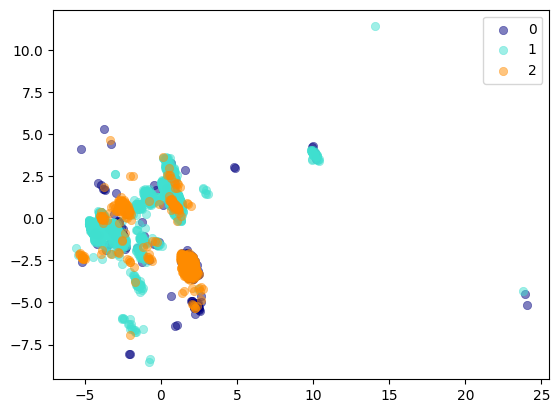

In [67]:
std = StandardScaler()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(std.fit_transform(X_train))
target_names = ['0','1','2']

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], color=color, alpha=.5, lw=0.5, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

### After SMOTETomek

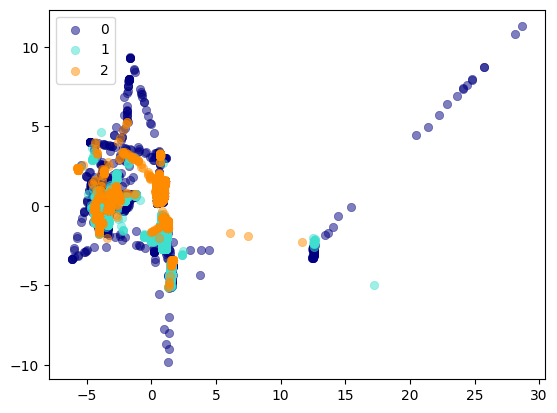

In [68]:
std = StandardScaler()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(std.fit_transform(X_train_res))
target_names = ['0','1','2']

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_pca[y_train_res == i, 0], X_pca[y_train_res == i, 1], color=color, alpha=.5, lw=0.5, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

# Building Models and Hyperparameter Tuning

### KNeighbors

In [12]:
kn = KNeighborsClassifier()
params = {
    'n_neighbors': np.arange(1,11,1),
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree','brute'],
    'leaf_size': np.arange(10,50,1),
    'p': [1,2],
    'metric': ['cityblock','cosine','euclidean','l1','l2','manhattan']
}
kn_search = RandomizedSearchCV(kn,
                               params,
                               cv=k_fold,
                               scoring=scoring,
                               refit='Accuracy',
                               n_iter=50,
                               n_jobs=-1).fit(X_train_res,y_train_res)
print('best crossval score: ',kn_search.best_score_)
kn_res = pd.DataFrame(kn_search.cv_results_)[['params','mean_test_Accuracy','mean_test_F1_macro']]
kn_res['classifier'] = 'KNeighbors'
print('valid: ', kn_search.score(X_valid,y_valid))
print('valid: ', kn_search.score(X_valid,y_valid))
print(kn_search.best_params_)

best crossval score:  0.8770621388613626
valid:  0.9151902410688353
{'weights': 'uniform', 'p': 1, 'n_neighbors': 1, 'metric': 'l1', 'leaf_size': 17, 'algorithm': 'ball_tree'}


In [99]:
pred_kn = kn_search.predict(X_valid)
check = pd.DataFrame({'pred': pred_kn, 'actual': y_valid})
check['correct'] = check['pred'] == check['actual']
incorrect = check[check['correct'] == False]
total = len(incorrect)
n_0 = len(incorrect[(incorrect['actual'] == 0) | (incorrect['pred'] == 0)]) 
p0w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 0)])
p0w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 0)])
p1w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 1)])
p1w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 1)])
p2w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 2)])
p2w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 2)])
print('total incorrect: ', total)
print('predicted 0, was 1:', p0w1)
print('predicted 0, was 2:', p0w2)
print('predicted 1, was 0:', p1w0)
print('predicted 1, was 2:', p1w2)
print('predicted 2, was 0:', p2w0)
print('predicted 2, was 1:', p2w1)
print(f'total 2-0 confusions: {p0w2+p2w0}/{total}')
print(f'total 1-0 confusions: {p0w1+p1w0}/{total}')
print(f'total 2-1 confusions: {p1w2+p2w1}/{total}')
print(f'number of errors involving 0: {n_0}/{total}')

total incorrect:  445
predicted 0, was 1: 134
predicted 0, was 2: 240
predicted 1, was 0: 19
predicted 1, was 2: 4
predicted 2, was 0: 41
predicted 2, was 1: 7
total 2-0 confusions: 281/445
total 1-0 confusions: 153/445
total 2-1 confusions: 11/445
number of errors involving 0: 434/445


### XGBoost
Linear booster consistently scores lower. Removed from grid
Reference: https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

In [100]:
class_weights_dict = {0: 2, 1: 0.2, 2: 0.6}
class_weights = class_weight.compute_sample_weight(class_weight=class_weights_dict, y=y_train)
xgb = XGBClassifier(objective='multi:softmax', tree_method='exact', num_class=3)
params = {
    'booster' : ['gbtree'],
    'eta': np.linspace(0.01,0.3,20),
    'gamma': np.linspace(0,3,20),
    'max_depth': np.arange(3,20,1),
    'min_child_weight': np.linspace(0,10,20),
    'subsample': [0.5,1],
    'lambda': np.linspace(0,5,20),
    'alpha': np.linspace(0,5,20)
}
xgb_search = RandomizedSearchCV(xgb,
                                params,
                                cv=k_fold,
                                scoring=scoring,
                                refit='Accuracy',
                                n_jobs=None,
                                n_iter=40
                                ).fit(X_train,y_train,sample_weight=class_weights)
print('best crossval score: ',xgb_search.best_score_)
xgb_res = pd.DataFrame(xgb_search.cv_results_)[['params','mean_test_Accuracy','mean_test_F1_macro_deceased','mean_test_F1_macro']]
xgb_res['classifier'] = 'XGBoost'
print('valid: ', xgb_search.score(X_valid,y_valid))
print(xgb_search.best_params_)

best crossval score:  0.9249762522221088
valid:  0.9233226837060703
{'subsample': 1, 'min_child_weight': 4.7368421052631575, 'max_depth': 6, 'lambda': 3.4210526315789473, 'gamma': 0.15789473684210525, 'eta': 0.11684210526315789, 'booster': 'gbtree', 'alpha': 0.2631578947368421}


In [101]:
pred_xgb = xgb_search.predict(X_valid)
check = pd.DataFrame({'pred': pred_xgb, 'actual': y_valid})
check['correct'] = check['pred'] == check['actual']
incorrect = check[check['correct'] == False]
total = len(incorrect)
n_0 = len(incorrect[(incorrect['actual'] == 0) | (incorrect['pred'] == 0)]) 
p0w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 0)])
p0w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 0)])
p1w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 1)])
p1w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 1)])
p2w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 2)])
p2w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 2)])
print('total incorrect: ', total)
print('predicted 0, was 1:', p0w1)
print('predicted 0, was 2:', p0w2)
print('predicted 1, was 0:', p1w0)
print('predicted 1, was 2:', p1w2)
print('predicted 2, was 0:', p2w0)
print('predicted 2, was 1:', p2w1)
print(f'total 2-0 confusions: {p0w2+p2w0}/{total}')
print(f'total 1-0 confusions: {p0w1+p1w0}/{total}')
print(f'total 2-1 confusions: {p1w2+p2w1}/{total}')
print(f'number of errors involving 0: {n_0}/{total}')

total incorrect:  264
predicted 0, was 1: 13
predicted 0, was 2: 122
predicted 1, was 0: 42
predicted 1, was 2: 7
predicted 2, was 0: 74
predicted 2, was 1: 6
total 2-0 confusions: 196/264
total 1-0 confusions: 55/264
total 2-1 confusions: 13/264
number of errors involving 0: 251/264


### Compiling CV Results

In [102]:
# after concatenating all into all_res:
all_res = pd.concat([kn_res, xgb_res])
all_res = all_res[['classifier','params','mean_test_Accuracy','mean_test_F1_macro_deceased','mean_test_F1_macro']]
all_res['params'] = all_res['params'].apply(lambda x: str(x)[1:-1].replace('\'','').replace(': ','=').replace(', ',','))
all_res.to_csv('res.csv', index=False)
all_res

,classifier,params,mean_test_Accuracy,mean_test_F1_macro_deceased,mean_test_F1_macro
0,KNeighbors,"weights=distance,p=1,n_neighbors=6,metric=manh...",0.873387,NaN,0.869667
1,KNeighbors,"weights=uniform,p=1,n_neighbors=9,metric=eucli...",0.843379,NaN,0.838038
2,KNeighbors,"weights=distance,p=1,n_neighbors=2,metric=city...",0.866676,NaN,0.865059
3,KNeighbors,"weights=distance,p=2,n_neighbors=4,metric=l1,l...",0.875880,NaN,0.873036
4,KNeighbors,"weights=distance,p=2,n_neighbors=5,metric=city...",0.872428,NaN,0.868247
...,...,...,...,...,...
35,XGBoost,"subsample=0.5,min_child_weight=0.5263157894736...",0.918440,0.387288,0.724127
36,XGBoost,"subsample=1,min_child_weight=2.105263157894736...",0.921127,0.406942,0.732919
37,XGBoost,"subsample=0.5,min_child_weight=1.0526315789473...",0.917496,0.330338,0.716938
38,XGBoost,"subsample=1,min_child_weight=0.0,max_depth=13,...",0.921926,0.406293,0.733297


# TODO:
- randomsearch strength is selecting from distributions. Might want to swap to scipy.stats instead of np.linspace or np.arange
- class balancing
- how to get F1 per class in GridSearchCV
- overfitting: precision over complexity, stop tuning when train precision plateaus